In [2]:
# Import modules
import pandas as pd

# plots
import seaborn as sns
import matplotlib.pyplot as plt
import atlaspy.core as apy

# stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import patsy
from patsy.contrasts import Poly
import numpy as np

In [19]:
# Import files
glimfile = pd.read_csv('/Users/siliangyan/Downloads/PYSC 380/JackKnife_connectivity/glimfile_jackknife_output.csv')

In [1]:
# Clean up the data
parameters = ["ID", "PatientCat", "Gender", "AgeScan1", "total_brain_volume", "mean_thickness", "mean_hippo_volume", "Global_Efficiency"] # Choose parameters to keep
data = glimfile.iloc[:, 113:193] # Data columns
mean_strength = pd.DataFrame({'mean_strength': glimfile.iloc[:, 111:193].mean(axis=1)}) # Calculate mean strength column

df = pd.concat([glimfile[parameters], data, mean_strength], axis = 1)

NameError: name 'glimfile' is not defined

In [35]:
# Remove outliers for efficiency
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5*IQR
    uppper_bound = Q3 + 1.5*IQR
    
    return df[(df[column] >= lower_bound) & (df[column] <= uppper_bound)]

In [31]:
# GLM

# Create results df
results_list = []

# Define group comparisons
comparisons = [
    ('Healthy Control', 'CHR'),
    ('CHR', 'First Episode Patient'),
    ('First Episode Patient', '3+ Year Patient'),
    ('Healthy Control', 'First Episode Patient'),
    ('Healthy Control', '3+ Year Patient'),
    ('CHR', '3+ Year Patient')
]


for i in df.iloc[:, 7:89].columns:
    
    # Remove outliers
    df_cleaned = remove_outliers_iqr(df, i).copy()

    # Convert categorical variables into categorical dtype
    df_cleaned['PatientCat'] = df_cleaned['PatientCat'].astype('category')
    df_cleaned['Gender'] = df_cleaned['Gender'].astype('category')
    
    # Create a list of p-values for FDR correction for this specific column's comparisons
    p_values = []   

    for ref_group, compare_group in comparisons:
        # Make a temporary df so the 'set_categories' does not remove none selected group
        temp_df = df_cleaned.copy()
        # Set the reference category as HC for PatientCat
        temp_df['PatientCat'] = temp_df['PatientCat'].cat.set_categories([ref_group, compare_group], ordered = True)
        
        # Define the formula for GLM
        formula = f"{i} ~ C(PatientCat) + C(Gender) + total_brain_volume + AgeScan1"
    
        # Fit the model
        model = smf.glm(formula = formula, data = temp_df, family = sm.families.Gaussian()).fit()
        
        # Fit the reduced model that represents the impact of gender and age, and it is used in effect size calculation
        reduced_formula = formula.replace("C(PatientCat) + ", "")
        reduced_model = smf.glm(formula=reduced_formula, data=temp_df, family = sm.families.Gaussian()).fit()
        
        # Calculate the effect size (Cohen's f^2)
        ss_full = model.deviance # Sum of suqare of the full model
        ss_reduced = reduced_model.deviance # Sum of suqare of the reduced model
        effect_size_f2 = (ss_reduced - ss_full) / ss_full
    
        # Extract desired parameter
        for param in model.params.index:
            # Check if the parameter is the PatientCat comparison
            if param.startswith("C(PatientCat)"):
                coefficient = model.params[param]
                p_value = model.pvalues[param]
                p_values.append(p_value) # Add into a list of collection of p-values
                
                results_list.append({
                    'Parameter': f"{i} - ({ref_group} vs {compare_group})",
                    'p-value': float(p_value),
                    'Effect Size (f^2)': float(effect_size_f2)
                    })
    
    # FDR correction
    adjusted_p_values = multipletests(p_values, method = 'fdr_bh')[1]

    # Update the results_list with adjusted p-values
    idx = 0
    for result in results_list:
        if result['Parameter'].startswith(i):  # Check if the result belongs to the current column
            result['FDR adjusted p-value'] = float(adjusted_p_values[idx])
            idx += 1
    
final_results = pd.DataFrame(results_list)
# Write to csv
final_results.to_csv("/Users/siliangyan/Downloads/PYSC 380/Aim_1_GLM.csv", index = False)

NameError: name 'df' is not defined

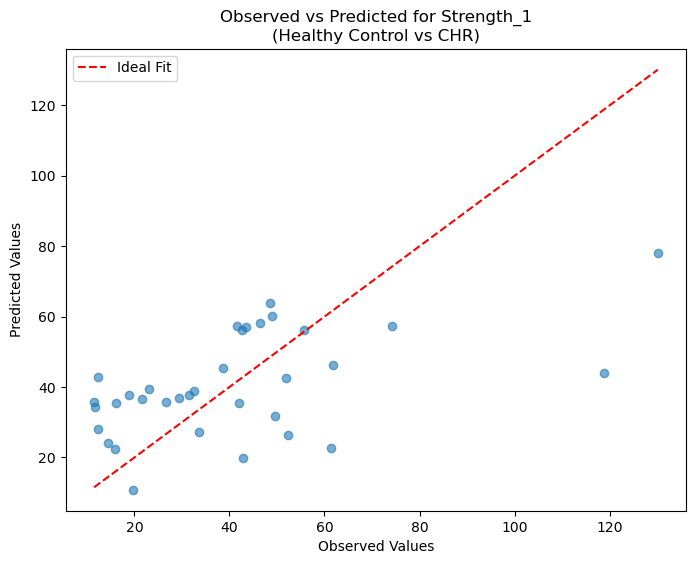

In [47]:
# Visualization of one of the GLM for the poster
var_name = 'Strength_1'

ref_group = 'Healthy Control'
compare_group = 'CHR'

df_cleaned = remove_outliers_iqr(df, var_name).copy()

# Convert categorical variables into category dtype
df_cleaned['PatientCat'] = df_cleaned['PatientCat'].astype('category')
df_cleaned['Gender'] = df_cleaned['Gender'].astype('category')

# Restrict the PatientCat to only the two groups for this visualization
df_cleaned = df_cleaned[df_cleaned['PatientCat'].isin([ref_group, compare_group])].copy()
df_cleaned['PatientCat'] = df_cleaned['PatientCat'].cat.set_categories([ref_group, compare_group], ordered=True)

# Define the formula for the GLM
formula = f"{var_name} ~ C(PatientCat) + C(Gender) + total_brain_volume + AgeScan1"

# Fit the model
model = smf.glm(formula=formula, data=df_cleaned, family=sm.families.Gaussian()).fit()

# Create predictions from the model
df_cleaned['predicted'] = model.predict(df_cleaned)
# Calculate residuals
df_cleaned['residuals'] = df_cleaned[var_name] - df_cleaned['predicted']

# --- Plot 1: Observed vs Predicted Values ---
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[var_name], df_cleaned['predicted'], alpha=0.6)
plt.plot([df_cleaned[var_name].min(), df_cleaned[var_name].max()],
         [df_cleaned[var_name].min(), df_cleaned[var_name].max()],
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title(f'Observed vs Predicted for {var_name}\n({ref_group} vs {compare_group})')
plt.legend()
plt.show()

In [44]:
### OPC ###
# Ensure 'PatientCat' is an ordered categorical variable.
# Adjust the category names as needed.
df['PatientCat'] = pd.Categorical(df['PatientCat'], categories=["Healthy Control", "CHR", "First Episode Patient", "3+ Year Patient"], ordered=True)

# Ensure 'Gender' is treated as categorical
df['Gender'] = pd.Categorical(df['Gender'])

# Get a list of all measure columns that start with "Strength_"
strength_columns = [col for col in df.columns if col.startswith("Strength_")]

# List to store our results.
results_list = []

# Loop over each measure
for measure in strength_columns:
    # Define the formula. C(PatientCat, Poly) applies orthogonal polynomial contrasts.
    formula = f"{measure} ~ C(PatientCat, Poly) + C(Gender) + AgeScan1 + total_brain_volume"
    
    # Build the design matrices.
    y, X = patsy.dmatrices(formula, df, return_type='dataframe')
    
    # Fit the OLS model.
    model = sm.OLS(y, X).fit()
    
    # Extract results for each polynomial contrast.
    for trend in ["Linear", "Quadratic", "Cubic"]:
        contrast_name = f"C(PatientCat, Poly).{trend}"
        if contrast_name in model.params:
            coef = model.params[contrast_name]
            pval = model.pvalues[contrast_name]
            results_list.append({
                "measure": f"{measure}_{trend}",
                "p_value": pval,
                "effect_size": coef
            })
        else:
            # If the contrast isn't found, you can print a warning or handle it otherwise.
            print(f"Trend {trend} not found for measure {measure}")

# Create a DataFrame from the results list.
results_df = pd.DataFrame(results_list)

# Print the results DataFrame.
print(results_df)

# Save the results to a CSV file.
results_df.to_csv("/Users/siliangyan/Downloads/PYSC 380/trend_results.csv", index=False)

                   measure   p_value  effect_size
0        Strength_1_Linear  0.294454    14.448340
1     Strength_1_Quadratic  0.854848     2.210576
2         Strength_1_Cubic  0.383040     9.617288
3        Strength_2_Linear  0.650474     6.553510
4     Strength_2_Quadratic  0.422128    10.223259
..                     ...       ...          ...
235  Strength_79_Quadratic  0.655891     6.358880
236      Strength_79_Cubic  0.308728    13.257246
237     Strength_80_Linear  0.294358    13.810772
238  Strength_80_Quadratic  0.271540    12.739459
239      Strength_80_Cubic  0.295060    11.042970

[240 rows x 3 columns]


Setting colormap to  Set3


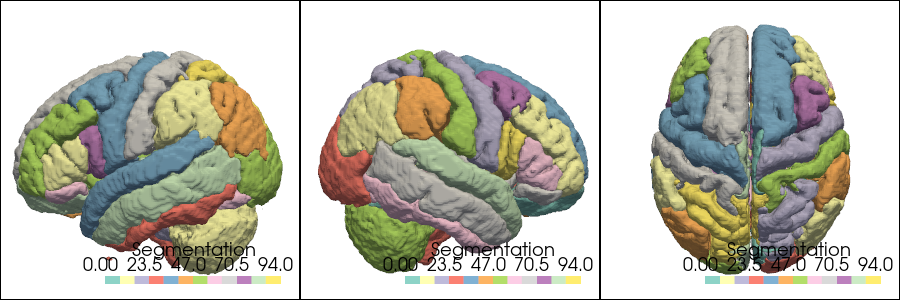

In [27]:
apy.plot_raw_atlas_lrt('dkt', cmap='Set3')

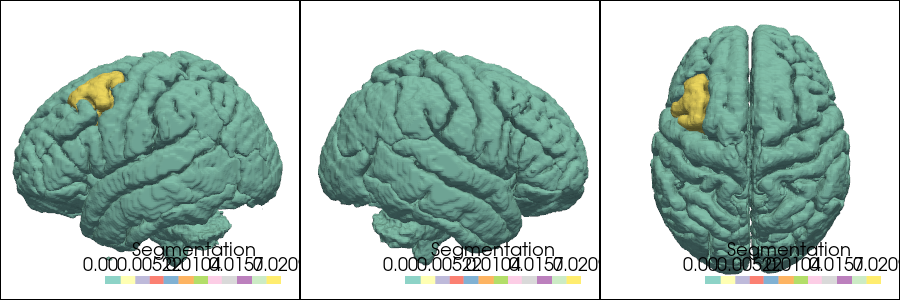

In [30]:
hc_vs_chr_dkt = pd.read_csv('/Users/siliangyan/Downloads/cortical_thickness_dkt.csv')
hc_vs_chr_dkt['roi_value'] = 0

hc_vs_chr_dkt.loc[3, 'roi_value'] = 0.0208872664908234

apy.plot_rois_atlas_lrt('dkt', hc_vs_chr_dkt)

In [11]:
print(hc_vs_chr_dkt)

                       atlas_region  atlas_index  roi_value
0                    ctx-lh-unknown         1000   0.000000
1                   ctx-lh-bankssts         1001   0.000000
2    ctx-lh-caudalanteriorcingulate         1002   0.000000
3        ctx-lh-caudalmiddlefrontal         1003   0.020887
4             ctx-lh-corpuscallosum         1004   0.000000
..                              ...          ...        ...
117                    CC_Posterior          251   0.000000
118                CC_Mid_Posterior          252   0.000000
119                      CC_Central          253   0.000000
120                 CC_Mid_Anterior          254   0.000000
121                     CC_Anterior          255   0.000000

[122 rows x 3 columns]


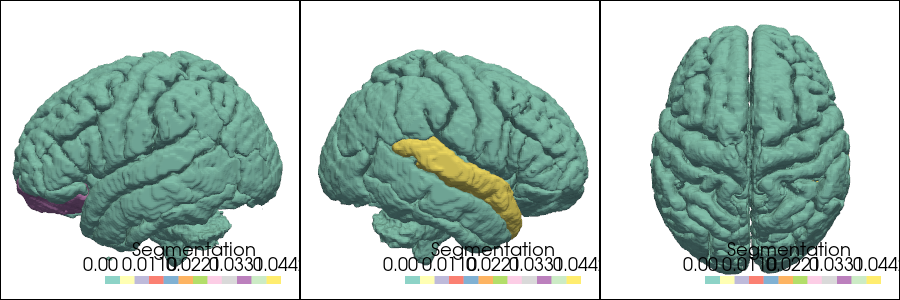

In [14]:
fep_vs_mep_dkt = pd.read_csv('/Users/siliangyan/Downloads/cortical_thickness_dkt.csv')
fep_vs_mep_dkt['roi_value'] = 0
rows_to_keep = [12, 66]
values = [0.0339005635733798, 0.0441692193384792]

fep_vs_mep_dkt.loc[rows_to_keep, 'roi_value'] = values

apy.plot_rois_atlas_lrt('dkt', fep_vs_mep_dkt)

In [15]:
print(fep_vs_mep_dkt)

                       atlas_region  atlas_index  roi_value
0                    ctx-lh-unknown         1000        0.0
1                   ctx-lh-bankssts         1001        0.0
2    ctx-lh-caudalanteriorcingulate         1002        0.0
3        ctx-lh-caudalmiddlefrontal         1003        0.0
4             ctx-lh-corpuscallosum         1004        0.0
..                              ...          ...        ...
117                    CC_Posterior          251        0.0
118                CC_Mid_Posterior          252        0.0
119                      CC_Central          253        0.0
120                 CC_Mid_Anterior          254        0.0
121                     CC_Anterior          255        0.0

[122 rows x 3 columns]


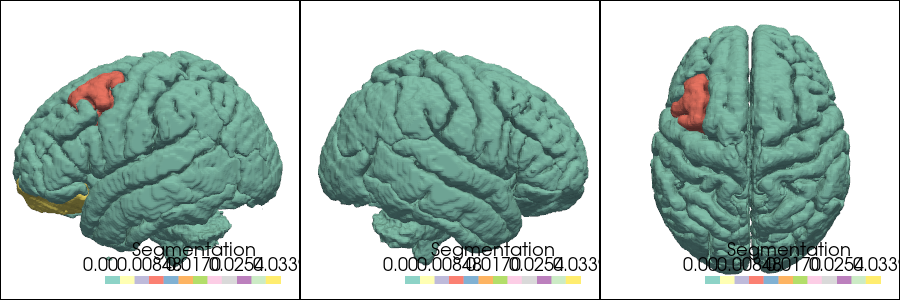

In [16]:
hc_vs_mep_dkt = pd.read_csv('/Users/siliangyan/Downloads/cortical_thickness_dkt.csv')
hc_vs_mep_dkt['roi_value'] = 0
rows_to_keep = [3, 12]
values = [0.00898037336933146, 0.0339005635733798]

hc_vs_mep_dkt.loc[rows_to_keep, 'roi_value'] = values

apy.plot_rois_atlas_lrt('dkt', hc_vs_mep_dkt)


In [17]:
fep_vs_mep_dkt = pd.read_csv('/Users/siliangyan/Downloads/cortical_thickness_dkt.csv')
fep_vs_mep_dkt_sub = fep_vs_mep_dkt.loc[[12, 3, 66]]
fep_vs_mep_dkt_sub

,atlas_region,atlas_index,roi_value
12,ctx-lh-lateralorbitofrontal,1012,0.890671
3,ctx-lh-caudalmiddlefrontal,1003,0.242749
66,ctx-rh-superiortemporal,2030,0.343595


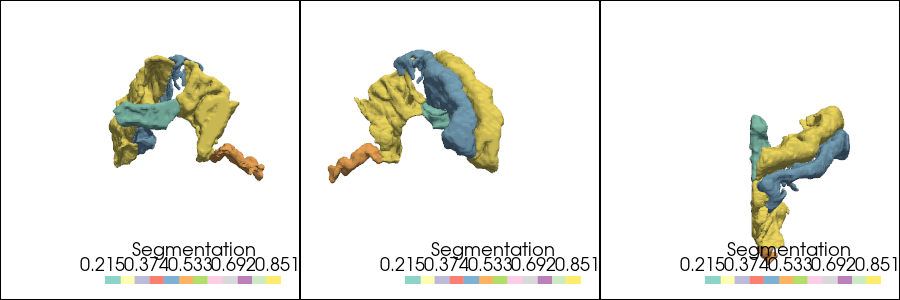

In [36]:
# Plot the 4 views
apy.plot_rois_atlas_lrt('dkt', p_values_sub)